In [77]:
#@title Librerias

import numpy as np # Númerica
import matplotlib.pyplot as plt # Gráficas
from scipy.integrate import quad, trapezoid, simpson, tplquad, fixed_quad # Integracón
from scipy.interpolate import CubicSpline, interp1d, lagrange, BarycentricInterpolator, CubicHermiteSpline # Interpolación
from scipy.optimize import fsolve, root_scalar, newton # Raíces
from scipy.stats import linregress # Regresión
import sympy as sp # Simbólica

# Parcial I - Métodos Computacionales
**2024-2**

---

*Nombre: David Alejandro Pérez*

*Identificación: 1001370011*

---
* Sea honest@
* El uso de herramientas de IA no está permitido
* Puede consultar la documentación de las librerias.
* Sea ordendado dando la solución a cada punto.
* *Asegurese que el notebook corra completamente*
* Suba su notebook al GitHub del curso y recuerde hacer pull-request

# 1

**(40 puntos)** La velocidad del agua $v$ [m/s] en la descarga de un tanque cilindrico a través de un tubo largo (como se muestra en la figura) se puede calcular como:

$$
v = \sqrt{2gH}\tanh{\left(\frac{\sqrt{2gH}}{2L}t\right)}
$$



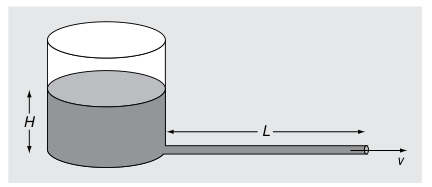

Donde $g$ = 9.81 m/s$^2$, H es la carga hidrostática inicial (m), L la longitud del tubo (m) y $t$ el tiempo transcurrido (s).


a) Escriba una función explicita para encontrar la velocidad de descarga en función de las variables asociadas.

In [43]:
g = 9.81
def v(H, L, t):
  return((2*g*H)**0.5)*np.tanh((((2*g*H)**0.5)*t)/2*L) # Función de la velocidad de descarga

*b)* Realice un gráfico de $v(H)$ para $0\leq H\leq 5$, con $L = 4$ m y para $t = 2.5$ s


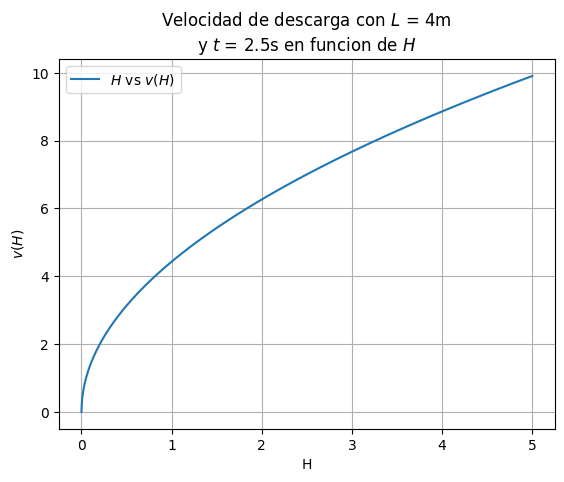

In [44]:
Lv = 4
tv = 2.5

H_lin = np.linspace(0, 5, 10000)
v_lin = v(H_lin, Lv, tv)

plt.plot(H_lin, v_lin, label = '$H$ vs $v(H)$')
plt.xlabel('H')
plt.ylabel('$v(H)$')
plt.title("""Velocidad de descarga con $L$ = 4m
y $t$ = 2.5s en funcion de $H$""")
plt.legend()
plt.grid()

*c)* Suponga que quiere conocer la carga hidrostática necesaria para tener una velocidad de 5 m/s transcurridos 2.5 s. Identifique gráficamente este valor.

1.274127412741274
Mediante la grafica podemos ver que la carga hidrostática necesaria para que el tanque tenga una velocidad de  5 m/s despues de 2.5s es 1.274127412741274m


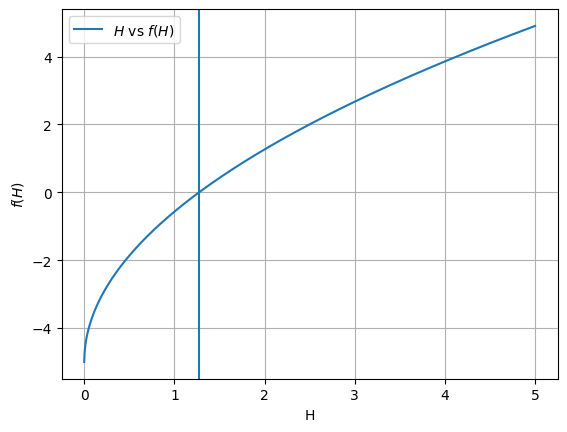

In [69]:
# Para esto, vamos a crear una nueva funcion

f_1 = lambda H, L, t: ((2*g*H)**0.5)*np.tanh((((2*g*H)**0.5)*t)/2*L) - 5
f_lin = f_1(H_lin, Lv, tv)

for i in range(len(f_lin)):
  if abs(f_lin[i]) <= 10e-4:
    v = H_lin[i]
    print(v)
    break

plt.plot(H_lin, f_lin , label = '$H$ vs $f(H)$')
plt.xlabel('H')
plt.ylabel('$f(H)$')
plt.axvline(v)
plt.legend()
plt.grid()

print(f"Mediante la grafica podemos ver que la carga hidrostática necesaria para que el tanque tenga una velocidad de  5 m/s despues de 2.5s es {v}m")

*d)* Realice una función que encuentre la raiz usando el método de bisección con una tolerancia de 1e-7, para esto puede modificar el siguiente pseudo-código:

```python
MÉTODO BISECCIÓN(f, a, b, tol)
    MIENTRAS (b - a)/2 > tol HACER
        c = (a + b)/2
        
        SI f(c) = 0 ENTONCES
            RETORNAR c
        
        SI f(a)*f(c) < 0 ENTONCES
            b = c
        SINO
            a = c
        FIN SI
    FIN MIENTRAS
    
    RETORNAR (a + b)/2
FIN MÉTODO
```

In [56]:
def metodo_biseccion(f, a, b, tol):
    while (b - a)/2 > tol:
        c = (a + b)/2

        if f(c) == 0:
            return c

        if f(a)*f(c) < 0:
            b = c
        else:
            a = c

    return (a + b)/2
f_n = lambda H: ((2*g*H)**0.5)*np.tanh((((2*g*H)**0.5)*tv)/2*Lv) - 5

Root = metodo_biseccion(f_n, 0.99, 1.5, 1e-7)

print(f"Mediante el método de bisección, la carga hidrostática necesaria para que el tanque tenga una velocidad de  5 m/s despues de 2.5s es {metodo_biseccion(f_n, 0.99, 1.5, 1e-7)}m")

Mediante el método de bisección, la carga hidrostática necesaria para que el tanque tenga una velocidad de  5 m/s despues de 2.5s es 1.2742099750041962m


*e)* Usando el método de `scipy.newton` encuentre el valor de la raiz

```python
# Método de Newton
root = newton(f, x0, fprime)  # fprime es la derivada
```

Compare sus respuestas con el numeral anterior y obtenga el error relativo.

In [58]:
# encontremos un polinomio interpolador para la derivada

H_int = np.linspace(0, 5, 8)
f_int = f_n(H_int)

dev_int = np.gradient(f_int, H_int)

d_f = BarycentricInterpolator(H_int, dev_int)

root = newton(f_n, 1.2, d_f)
root

error_relativo = abs(root - Root)/root

print(f" el error relativo entre estos dos métodos es de {error_relativo}")

 el error relativo entre estos dos métodos es de 1.1411551059174591e-08


# 2

**(30 puntos)** Usualmente algunas reacciones quimicas siguen el siguiente modelo:

$$
\frac{dc}{dt} = -kc^n
$$

donde $c$ es la concentración, $t$ el tiempo, $k$ la tasa de la reacción y $n$ su orden. Usando los siguientes datos:



```python
# Datos dados
t = np.array([10, 20, 30, 40, 50, 60])
c = np.array([3.52, 2.48, 1.75, 1.23, 0.87, 0.61])
```


*a)* Conociendo que el método de diferencias finitas se puede escribir como:

###  Diferencias finitas hacia adelante:
Aproximación de primer orden:
$$
f'(x_i) \approx \frac{f(x_{i+1}) - f(x_i)}{h}
$$

### Diferencias finitas hacia atrás:
Aproximación de primer orden:
$$
f'(x_i) \approx \frac{f(x_i) - f(x_{i-1})}{h}
$$

### Diferencias finitas centradas:
Aproximación de segundo orden:
$$
f'(x_i) \approx \frac{f(x_{i+1}) - f(x_{i-1})}{2h}
$$

Escribe una función explicita que calcule $dc/dt$ usando el método de diferencias finitas a partir de los valores de $c$ y $t$, luego grafique en función de t. *Ayuda: No es necesario interpolar* interpolar, mi religion.




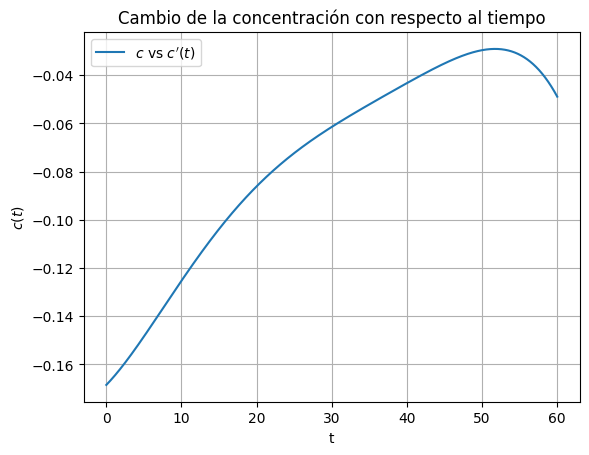

In [72]:
t = np.array([10, 20, 30, 40, 50, 60])
c = np.array([3.52, 2.48, 1.75, 1.23, 0.87, 0.61])

def finite_diff(x, y, h):
  diff = []
  for i in range(len(x)):

    if i == 0 and len(x) != 1:

      d_f = (y(x[i] + h) - y(x[i]))/h      # forward
      diff.append(d_f)

    elif i == len(x) - 1 and len(x) != 1:


      d_f = (y(x[i] + h) - y(x[i] - h))/h   # Backward
      diff.append(d_f)

    else:

      d_f = (y(x[i]) - y(x[i] - h))/h    # centrada
      diff.append(d_f)

  return diff

# Vamos a interpolar porque soy rebelde

c_t = BarycentricInterpolator(t, c) # polinomio interpolador de la concentracion

dev = finite_diff(t, c_t, 10e-6) # Array con las derivadas para cada t dado

d_c = BarycentricInterpolator(t, dev)


# Grafica

t_lin = np.linspace(0, 60, 10000)
d_lin = d_c(t_lin)

plt.plot(t_lin, d_lin , label = "$c$ vs $c'(t)$")
plt.xlabel('t')
plt.ylabel('$c(t)$')
plt.title("Cambio de la concentración con respecto al tiempo")
plt.legend()
plt.grid()


*b)* Compare el resultado anterior con `numpy.gradient`, se acercan?

*c)* Linealice la ecuación inicial (para esto puede usar log) y encuentre los valores correspondientes a $k$ y $n$


```python
# Realizar el ajuste lineal
slope, intercept, r_value, p_value, std_err = linregress(x, y)
```

*d)* Finalmente, usando los valores de $k$ y $n$ grafique $dc/dt$ y compare con los datos de la tabla. ¿Se comportan igual, determine el error máximo?

# 3
**(30 puntos)** Considere los  datos de concentración del punto anterior

```python
# Datos dados
t = np.array([10, 20, 30, 40, 50, 60])
c = np.array([5.29, 6.24, 7.02, 7.68, 8.25, 8.77])
```

*a)* Realice un gráfico de $c(t)$





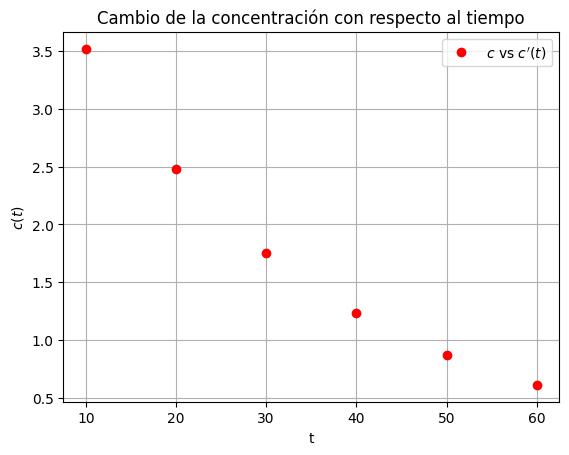

In [76]:


plt.plot(t, c , 'ro', label = "$c$ vs $c'(t)$")
plt.xlabel('t')
plt.ylabel('$c(t)$')
plt.title("Cambio de la concentración con respecto al tiempo")
plt.legend()
plt.grid()

*b)* Usando la interpolación de `scipy.interpolate.lagrange` y de `scipy.interpolate.CubicHermiteSpline` obtenga el polinomio interpolador de lagrange llamado `poly_lagrange` y de Hermite `poly_Hermite` para los datos datos.

In [78]:
poly_lagrange = lagrange(t, c)
poly_Hermite = CubicHermiteSpline(t, c, dev)

*c)* Conociendo que `scipy.interpolate.lagrange` devuelve un array tipo Polynomial, use la siguiente rutina para encontrar la derivada:

``` python
from numpy.polynomial.polynomial import Polynomial

# Convertir a un objeto Polynomial para facilitar la derivación
poly_coef = Polynomial(poly_lagrange.coef[::-1])  # Convertimos los coeficientes
derivative = poly_coef.deriv()  # Calculamos la derivada
```

Luego, grafique $dc/dt$ en función del tiempo $t$ y compare con la función
$$
\frac{dc}{dt} = -kc^n
$$

con $k = 3$ y $n = -2$

In [82]:
from numpy.polynomial.polynomial import Polynomial

# Convertir a un objeto Polynomial para facilitar la derivación
poly_coef = Polynomial(poly_lagrange.coef[::-1])  # Convertimos los coeficientes
derivative = poly_coef.deriv()  # Calculamos la derivada

k = 3
n = -2

c_t =[]

for i in range(len(c)):
  c_t[i] = k*(c[i])**n



plt.plot(t, c , 'ro', label = "$c$ vs $c'(t)$")
plt.plot(t_lin, derivative(t_lin))
plt.xlabel('t')
plt.ylabel('$c(t)$')
plt.title("Cambio de la concentración con respecto al tiempo")
plt.legend()
plt.grid()

IndexError: list assignment index out of range

*d)* Realice un gráfico del error absoluto